In [2098]:

import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import metrics
from pickle import dump
from pickle import load
import re
import sweetviz as sv
import datetime
final_date = '2021-01-18'

In [2099]:
def iqrfilter(df, colname, bounds = [.25, .75]):
    s = df[colname]
    Q1 = df[colname].quantile(bounds[0])
    Q3 = df[colname].quantile(bounds[1])
    IQR = Q3 - Q1
    print(IQR,Q1,Q3,Q1 - 1.5*IQR,Q3+ 1.5 * IQR)
    if bounds[0]==0:
        return df[~s.clip(*[Q1,Q3+ 1.5 * IQR]).isin([Q1,Q3+ 1.5 * IQR])]
    else:
        return df[~s.clip(*[Q1 - 1.5*IQR,Q3+ 1.5 * IQR]).isin([Q1 - 1.5*IQR,Q3+ 1.5 * IQR])]

### normalize 釋義:是否對數據進行標準化處理
設置:bool型,可選,默認False,建議將標準化的工作放在訓練模型之前,通過設置sklearn.preprocessing.StandardScaler來實現，而在此處設置為false 當fit_intercept設置為false的時候，這個參數會被自動忽略。如果為True,回歸器會標準化輸入參數：減去平均值，並且除以相應的二範數


### copy_X 釋義:是否對X複製
設置:bool型、可選、默認True,如為false，則即經過中心化，標準化後，把新數據覆蓋到原數據上

### n_jobs釋義:計算時設置的任務個數,
這一參數的對於目標個數>1（n_targets>1）且足夠大規模的問題有加速作用
設置:int or None, optional, 默認None,如果選擇-1則代表使用所有的CPU。


In [2100]:
def trainLR(df):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    import joblib

    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.001,random_state=587)
    model = LinearRegression(fit_intercept=False, normalize=False, copy_X=False) #fit_intercept=False
   
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    #print(y_predict)
    print("r2:", model.score(X_test, y_test))# 拟合优度R2的输出方法
    print("MAE:", metrics.mean_absolute_error(y_test, y_predict))# 用Scikit_learn计算MAE
    print("MSE:", metrics.mean_squared_error(y_test, y_predict)) # 用Scikit_learn计算MSE
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))# 用Scikit_learn计算RMSE
    print("intercept_ :",model.intercept_)
    # print("coef_", model.coef_)
    joblib.dump(model, 'LR_model')
    # print(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))#計算準確率分數)

    # print((y_predict-y_test)/y_test)

    return y_predict

In [2101]:
def testLR(df):
    from sklearn.linear_model import LinearRegression
    import joblib
    X_test,y_test = preHandleDat(df,False)
    # print(X_test)
    #print(X_test,y_test)
    loaded_model = joblib.load('LR_model')
    y_predict = loaded_model.predict(X_test)
    df['predict'] = y_predict
    
    loaded_model.score(X_test, y_test)
    print("r2:", loaded_model.score(X_test, y_test))
   
    # y_test real 与 y_predict的可视化
    plt.figure(figsize=(6, 5))# 设置图片尺寸
    t = np.arange(len(X_test))# 创建t变量
    plt.plot(t, y_test, 'r', linewidth=1, marker='.', label='real') # 绘制y_test曲线
    plt.plot(t, y_predict, 'g', linewidth=1, marker='.', label='predict') # 绘制predict曲线
    plt.legend()
    plt.savefig('./Result/test2.png')
    return df


In [2102]:
def preHandleDat(df,isTrain=True):
    from sklearn.preprocessing import StandardScaler #平均&變異數標準化 平均值為0，方差為1。
    from sklearn.preprocessing import MinMaxScaler #最小最大值標準化[0,1]
    from sklearn.preprocessing import RobustScaler #中位數和四分位數標準化
    from sklearn.preprocessing import MaxAbsScaler #絕對值最大標準化

    #=================
    #刪除不必要的欄位
    #=================
    drop_cols=['MFG_DATE','ARRIVAL_WIP_QTY','MOVE_QTY','WIP_QTY']
    num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','NO_HOLD_QTY','IS_HOLIDAY'] 
    target_cols=['TRCT']
    cat_cols = ['TOOLG_ID']
    df = df.drop(drop_cols, axis=1)
    #df_train['Finish']=np.where(df_train['TOOLG_ID_NEXT'].isnull(), 1, 0).astype(str)
    #df_train['WEEKDAY']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()
    # df['MFG_DATE']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d')
    #'IS_HOLIDAY'
     
    # df = df.drop('WIP_QTY', axis=1)
    # df = df.sort_values('NO_HOLD_QTY')
    # print("DATA Start====")
    # print(df.info())  
    #========================
    # 缺漏值填空
    #========================
    # df = df.fillna(df.median())
    df = df.fillna(method='bfill')
    # df = df.fillna(df.mean())     
    # df = df.dropna() # 刪除null值   

    #==================================================
    #1.特徵縮放
    #==================================================
    
    #特徵縮放欄位 List(排除Target TRCT)==================
    # num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','MOVE_QTY','ARRIVAL_WIP_QTY','RUN_WIP_RATIO','CLOSE_WIP_QTY','MANAGEMENT_WIP_QTY','C_TC','C_CLOSE_WIP','C_TOOLG_LOADING','C_TOOL_LOADING','DISPATCHING','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','[BACKUP]','REWORK_RATE','QUE_LOT_RATE','SAMPLING_RATE','NUM_RECIPE','CHANGE_RECIPE','BATCH_SIZE']

   #'ARRIVAL_WIP_QTY',,'WIP_QTY'
    df_train_scal = df
    if isTrain:
        
        
        #rescaling 特徵縮放 StandardScaler-------------------------------------
        # scaler = StandardScaler()
        # scaler.fit(df_train[num_cols])
        # df_train_scal[num_cols]= scaler.transform(df_train_scal[num_cols])
    
        #rescaling 特徵縮放 MinMaxScaler-------------------------------------
        scaler = MinMaxScaler()
        scaler.fit(df[num_cols])
        df_train_scal[num_cols]= scaler.transform(df_train_scal[num_cols])

        #rescaling 特徵縮放 RobustScaler-------------------------------------
        # scaler = RobustScaler()
        # scaler.fit(df_train[num_cols])
        # df_train_scal[num_cols] = scaler.transform(df_train_scal[num_cols])
        
       
        dump(scaler, open('scaler.pkl', 'wb'))
        # # save the scaler
        # dump(scaler, open('scaler.pkl', 'wb'))
    else:
        # load the scaler
        scaler = load(open('scaler.pkl', 'rb'))
        df_train_scal[num_cols] = scaler.transform(df[num_cols])



     #==================================================
    #2.one hot encoder
    #==================================================
    # target_cols=['MOVE_QTY']
 
    global df2_train_eh_before
    df_train_eh =pd.get_dummies(df_train_scal.drop(target_cols, axis=1),columns=cat_cols)
    # save the scaler


    if isTrain:
        df2_train_eh_before = df_train_eh
    else:
        df_train_eh = df_train_eh.reindex(columns = df2_train_eh_before.columns, fill_value=0)

    df_train_scal.to_csv('./df_train_scal.csv')
    #print(df_train_scal.drop(target_cols, axis=1).describe())
    # print("one hot encoder====")
    # print(df_train_eh.info())


    # df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
    #df_test_eh = df_test_eh.reindex(columns = df_test_eh.columns, fill_value=0)
   
    #np.asarray(x).astype('float32')        
           
    X_dropped = np.asarray(df_train_eh)

    Y_dropped = np.asarray(df[target_cols]) 
    return X_dropped,Y_dropped
    

In [2103]:
def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df

In [2104]:
def EDA(df_train,targetfeat='MOVE_QTY'):
    
    pairwise_analysis='off' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
    report_train = sv.analyze([df_train, 'train'],
                                    target_feat= targetfeat
    )
    report_train.show_html(filepath='./sweetvizHTML/train_report.html' ) # 儲存為html的格式

    # compare_subsets_report = sv.compare_intra(df_train,
    #                                         df_train['Finish']==1, # 給條件區分
    #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
    #                                         target_feat='NO_HOLD_QTY',
    #                                         )

    # compare_subsets_report.show_html(filepath='./sweetvizHTML/HW2_Compare_report.html')

In [2105]:
df_train_orign=readDataFromFile('./data/TRCT_TrainingData_20210131.csv')
 
df_train_orign = df_train_orign.loc[df_train_orign['TOOLG_ID']=='PK_DUVKrF']
#df_train_orign['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
df_train_orign['MFG_DATE'] = df_train_orign['MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

df_train = df_train_orign
# df_train.info()
# 1. 查看缺失情况
# print(df_train.isnull().sum())
# print(df_train.describe())# 128683

#df2_test = df2_test.dropna()# 刪除null值

# 'MFG_DATE','TOOLG_ID','IS_HOLIDAY','M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','MOVE_QTY','ARRIVAL_WIP_QTY','RUN_WIP_RATIO','CLOSE_WIP_QTY','MANAGEMENT_WIP_QTY','C_TC','C_CLOSE_WIP','C_TOOLG_LOADING','C_TOOL_LOADING','DISPATCHING','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','[BACKUP]','REWORK_RATE','QUE_LOT_RATE','SAMPLING_RATE','NUM_RECIPE','CHANGE_RECIPE','BATCH_SIZE'
# num_cols=['WIP_QTY','NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
# missData(df_train)

#刪除columns 值是空的()
df_train = df_train.dropna(axis=1, how='all')
 
# #刪除rows ,target值是空的()
df_train = df_train[df_train['MOVE_QTY'].notna()]
df_train = df_train[df_train['NO_HOLD_QTY'].notna()]
# df_train['TRCT']= df_train['NO_HOLD_QTY']/df_train['MOVE_QTY']
df_train['TRCT']= df_train['NO_HOLD_QTY']/df_train['MOVE_QTY']

df_train.info()

df_train.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 230 to 128575
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MFG_DATE         377 non-null    datetime64[ns]
 1   TOOLG_ID         377 non-null    object        
 2   IS_HOLIDAY       377 non-null    float64       
 3   M_NUM            377 non-null    float64       
 4   UP_TIME          377 non-null    float64       
 5   C_UP_TIME        377 non-null    float64       
 6   LOT_SIZE         377 non-null    float64       
 7   C_LOT_SIZE       377 non-null    float64       
 8   EQP_UTIL         377 non-null    float64       
 9   C_EQP_UTIL       377 non-null    float64       
 10  U                377 non-null    float64       
 11  PROCESS_TIME     377 non-null    float64       
 12  WIP_QTY          377 non-null    float64       
 13  NO_HOLD_QTY      377 non-null    float64       
 14  MOVE_QTY         377 non-null    floa

MFG_DATE           0
TOOLG_ID           0
IS_HOLIDAY         0
M_NUM              0
UP_TIME            0
C_UP_TIME          0
LOT_SIZE           0
C_LOT_SIZE         0
EQP_UTIL           0
C_EQP_UTIL         0
U                  0
PROCESS_TIME       0
WIP_QTY            0
NO_HOLD_QTY        0
MOVE_QTY           0
ARRIVAL_WIP_QTY    0
RUN_WIP_RATIO      0
C_TC               0
HOLD_RATE          0
ENG_LOT_RATE       0
HOT_LOT_RATE       0
QUE_LOT_RATE       0
TRCT               0
dtype: int64

## 資料分析 Tool

In [2106]:

#資料分析 Tool
# EDA(df_train,'TRCT')
#df_train.info()

In [2107]:
# 檢查資料處理  value  是不是有 無限大
# x,y=preHandleDat(df_train)
 
# # # np.isnan(y.any()) #and gets False
# # # np.isfinite(y.all()) #and gets True

# print(np.all(np.isfinite(x)))
# print(np.all(np.isfinite(y)))

# #trainLR(df_train)


In [2108]:

# df_train1 = df_train[df_train['MFG_DATE'] <  pd.to_datetime('2021-01-20')]
df_train1 = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]

# df_train1 =iqrfilter(df_train1,'TRCT',[0, .75]) 
df_train1['MFG_DATE'].max()


Timestamp('2021-01-17 00:00:00')

# 模型 訓練

In [2109]:
# EDA(df_train1,'TRCT')

r2: nan
MAE: 0.003579008257843741
MSE: 1.280930010971369e-05
RMSE: 0.003579008257843741
intercept_ : [0.35900351]
r2: 0.8870300671374051


0.9672689900890518

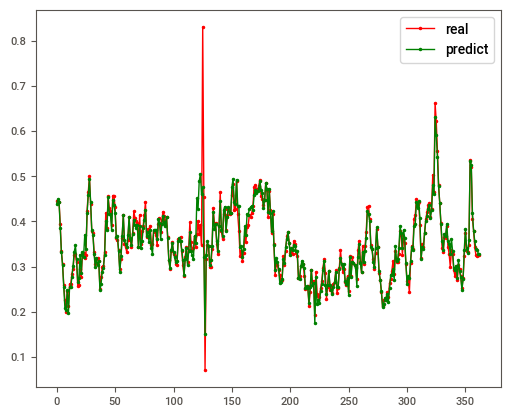

In [2110]:
# trainLR(df_train)

trainLR(df_train1)
def_result = testLR(df_train1)
def_result['acc'] = (1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))
def_result['acc'].sum()/def_result.shape[0]


# 推估當天 28天 df_sum28

##取得當天的生產資訊
#### C_LOT_SIZE
#### LOT_SIZE
#### PROCESS_TIME
#### WIP_QTY
#### NO_HOLD_QTY
#### ARRIVAL_WIP_QTY
#### HOLD_RATE
#### ENG_LOT_RATE
#### HOT_LOT_RATE
#### QUE_LOT_RATE

In [1954]:
def getsum28(df_train,final_date):
    
    test = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]
    # test['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
    print(test['MFG_DATE'].max())
    df = test.groupby('TOOLG_ID').apply(lambda x: x.set_index('MFG_DATE').resample('1D').first())
    # df = test.groupby('User').apply(lambda x: x.set_index('Date').resample('1D').first())
    num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY', 'ARRIVAL_WIP_QTY','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
    # num_cols=['M_NUM']
    # df1[num_cols] = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean())
    # df1 = df.groupby(level=0)['Value']
    #         .apply(lambda x: x.shift().rolling(min_periods=1,window=2).mean())
    #         .reset_index(name='Value_Average_Past_2_days')

    df_sum28 = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean()).reset_index()
    #df_train1['MFG_DATE'].max()
    df_sum28['MFG_DATE'].max()
    #抓最後一天的數據 來預測當天的值 df_test_today
    df_test_today=df_sum28.loc[df_sum28['MFG_DATE']==df_sum28['MFG_DATE'].max()]
     
    df_test_today['MFG_DATE'] = df_sum28['MFG_DATE'].max()+ datetime.timedelta(days=1)
    weekno = df_test_today['MFG_DATE'].max().weekday()

    if weekno < 5:
        df_test_today['IS_HOLIDAY'] = 1.0527
    else:  # 5 Sat, 6 Sun
        df_test_today['IS_HOLIDAY'] =1



    real_data_cols_withkeys =['MFG_DATE','TOOLG_ID','C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
    real_data_cols =['C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
    df_map_today = df_train[real_data_cols_withkeys] 
    df_map_today=df_map_today.loc[df_map_today['MFG_DATE']==df_test_today['MFG_DATE'].max()]

    for index, row in df_test_today.iterrows():
        r = df_map_today[real_data_cols].loc[(df_map_today['MFG_DATE']==row['MFG_DATE'])  & (df_map_today['TOOLG_ID']==row['TOOLG_ID'])]
        if(r.any(axis=None)):
            for col in real_data_cols:
                df_test_today.loc[index,col]  =r[col].values
        else:
            df_test_today.drop(index, inplace=True)
        
    #測試集的答案 驗證用
    df_test_today['TRCT']= df_test_today['NO_HOLD_QTY']/df_test_today['MOVE_QTY']
    # df_test_today['TRCT']= df_test_today['MOVE_QTY']
    return df_test_today

In [1955]:
df = pd.DataFrame(columns = df_train.columns)

for i in range(15):
    _final_date =   datetime.datetime.strptime(final_date, "%Y-%m-%d")+ datetime.timedelta(days=i)
    _df = getsum28(df_train,_final_date)
    df = df.append(_df,ignore_index=True)
    
# print(df.shape,df.head()) 

2021-01-09 00:00:00
2021-01-10 00:00:00
2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00
(15, 23)     MFG_DATE   TOOLG_ID IS_HOLIDAY  M_NUM   UP_TIME  C_UP_TIME   LOT_SIZE  \
0 2021-01-10  PK_DUVKrF          1   32.0  0.947880   0.138878  21.493409   
1 2021-01-11  PK_DUVKrF     1.0527   32.0  0.935797   0.141510  21.842157   
2 2021-01-12  PK_DUVKrF     1.0527   32.0  0.935236   0.141583  21.591393   
3 2021-01-13  PK_DUVKrF     1.0527   32.0  0.935565   0.141530  21.661907   
4 2021-01-14  PK_DUVKrF     1.0527   32.0  0.936056   0.141454  21.370976   

   C_LOT_SIZE  EQP_UTIL  C_EQP_UTIL  ...  NO_HOLD_QTY  MOVE_QTY  \
0    0.196599  0.975017    0.345713  ...      23721.0   45652.0   
1    0.193457  0.973428    0.346273  ...      18072.0   44558.0   
2    0.195742  0.973492    

In [1956]:
print(df.shape)
df.to_csv('./data/MyToday20200120_CT.csv')

(15, 23)


In [1957]:
df

,MFG_DATE,TOOLG_ID,IS_HOLIDAY,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,C_EQP_UTIL,...,NO_HOLD_QTY,MOVE_QTY,ARRIVAL_WIP_QTY,RUN_WIP_RATIO,C_TC,HOLD_RATE,ENG_LOT_RATE,HOT_LOT_RATE,QUE_LOT_RATE,TRCT
0,2021-01-10,PK_DUVKrF,1,32.0,0.947880,0.138878,21.493409,0.196599,0.975017,0.345713,...,23721.0,45652.0,2290.916667,0.153080,0.350752,0.073604,0.008214,0.030995,0.447888,0.519605
1,2021-01-11,PK_DUVKrF,1.0527,32.0,0.935797,0.141510,21.842157,0.193457,0.973428,0.346273,...,18072.0,44558.0,1619.250000,0.155291,0.356764,0.066499,0.007720,0.031195,0.471273,0.405584
2,2021-01-12,PK_DUVKrF,1.0527,32.0,0.935236,0.141583,21.591393,0.195742,0.973492,0.346246,...,16935.0,44651.0,1806.958333,0.153998,0.357032,0.089964,0.013863,0.026517,0.443708,0.379275
3,2021-01-13,PK_DUVKrF,1.0527,32.0,0.935565,0.141530,21.661907,0.195037,0.973729,0.346160,...,14570.0,42479.0,1661.250000,0.154540,0.357629,0.098219,0.014030,0.033122,0.456626,0.342993
4,2021-01-14,PK_DUVKrF,1.0527,32.0,0.936056,0.141454,21.370976,0.197690,0.973886,0.346101,...,13588.0,41823.0,1712.583333,0.154893,0.357674,0.091609,0.011740,0.031849,0.443512,0.324893
5,2021-01-15,PK_DUVKrF,1.0527,32.0,0.936048,0.141444,21.467586,0.196882,0.974334,0.345938,...,13583.0,42055.0,1726.375000,0.153644,0.358162,0.088638,0.012959,0.027892,0.463916,0.322982
6,2021-01-16,PK_DUVKrF,1,32.0,0.935424,0.141527,21.857357,0.193353,0.975065,0.345675,...,14219.0,43671.0,1864.291667,0.153118,0.358695,0.077470,0.009572,0.029127,0.454924,0.325594
7,2021-01-17,PK_DUVKrF,1,32.0,0.936239,0.141392,22.045249,0.191678,0.975457,0.345530,...,14326.0,43848.0,1829.166667,0.153210,0.358444,0.079184,0.008165,0.023718,0.460637,0.326720
8,2021-01-18,PK_DUVKrF,1.0527,32.0,0.937196,0.141245,21.836465,0.193490,0.975388,0.345548,...,13815.0,42996.0,1753.500000,0.154212,0.358834,0.087913,0.009210,0.028421,0.440343,0.321309
9,2021-01-19,PK_DUVKrF,1.0527,32.0,0.937739,0.141156,22.200957,0.190362,0.975386,0.345542,...,11039.0,41760.0,1624.458333,0.155119,0.358806,0.101512,0.008908,0.026964,0.430939,0.264344


r2: 0.9110818457792016


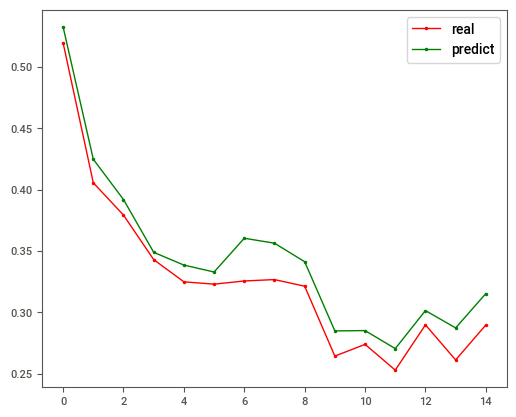

In [1959]:
# testLR(df_test_todayOK)
# testLR(df).to_csv('./data/MyToday20200120_result_CT.csv')

def_result = testLR(df)
# testLR( df_train[df_train['MFG_DATE'] ==  pd.to_datetime(final_date)  + datetime.timedelta(days=1)])

In [1980]:
#計算準確率分數

(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))

0     0.974926
1     0.952645
2     0.966564
3     0.982654
4     0.957973
5     0.969350
6     0.893097
7     0.909204
8     0.937853
9     0.922285
10    0.959037
11    0.930685
12    0.959816
13    0.900070
14    0.911696
dtype: float64

r2: 0.8813297505243429


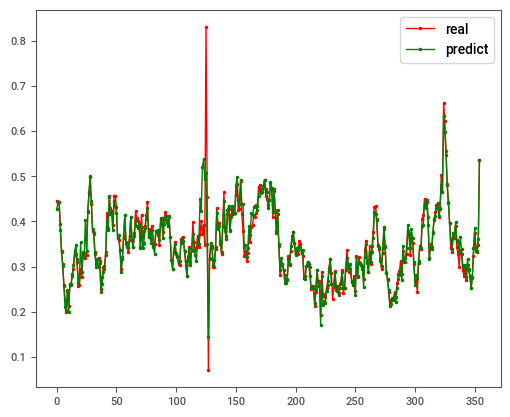

342.67481805032446

0.9652811776065477